In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

#gsheet read db
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow, Flow 
from google.auth.transport.requests import Request 

import os, sys, pickle

%matplotlib inline

# 1. Fetch Data

In [2]:
# Gsheet read to pdf
def gsheetRead_GoogleWay(dpath):
    results = None
    
    scope =  ['https://www.googleapis.com/auth/spreadsheets'] 

    creds = None
    if os.path.exists( 'token.pickle'):
        with open( 'token.pickle', 'rb') as fd:
            creds = pickle.load( fd ) 
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh( Request() ) 
        else:
            flow = InstalledAppFlow.from_client_secrets_file( 'gsheet_get.json', scope) 
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as fd:
            pickle.dump( creds, fd) 
    
    service = build('sheets', 'v4', credentials=creds, cache_discovery=False) 

    sheet = service.spreadsheets()
    reader = sheet.values().get(spreadsheetId=dpath[0], range=dpath[1]).execute() 

    results = reader.get('values', None)  

    return results  
''

'''
Returns two dicts : responses_db(class_category : response_paragraph) and input_phrases(input_que : class_category )
'''
def unpack_FaqGsheet(db_path, training_set, removeHeader=True):     
    start_idx = 1 if removeHeader else 0
    ## 1. unpack responses set @ retrieval class_cat : response 
    gsheet_faq_db = {} 
    tmp = gsheetRead_GoogleWay( db_path )[start_idx: ] ## ignore header row TODO: refactor at caller to decide
    for row in tmp:
        if len(row) > 2:
            gsheet_faq_db[ row[1] ] = row[2] 

    ## 2. unpack training set  que : class_cat       
    gsheet_faq_training_set_db = {}
    tmp = gsheetRead_GoogleWay( training_set )[start_idx: ]
    for row in tmp:
        if len(row) > 1:
            gsheet_faq_training_set_db[ row[0] ] = row[1] 

    return gsheet_faq_db, gsheet_faq_training_set_db 


db_pathz = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]


In [3]:
res_path, que_path = db_pathz

dict_responses_db, dict_inputs_db = unpack_FaqGsheet( res_path, que_path)

print( "Loaded {} responses and {} training input text".format(len(dict_responses_db), len(dict_inputs_db)))

Loaded 91 responses and 141 training input text


In [4]:
# make pandas data frame
db_faq = pd.DataFrame( dict_responses_db.items() )
db_faq.columns = ['class_category', 'response_paragraph']
db_faq.head()

,class_category,response_paragraph
0,pandemic_define,A pandemic is an epidemic (infectious disease ...
1,pandemic_causes,A pandemic can occur when a new virus emerges ...
2,pandemic_WHO,On 11 March WHO declared COVID-19 a pandemic. ...
3,pandemic_impact,The health impact of a pandemic on the communi...
4,corana_viruses,Coronaviruses are a large family of viruses. S...


In [5]:
# make pandas data frame
db_training = pd.DataFrame( dict_inputs_db.items() )
db_training.columns = [ 'input_text', 'class_category']
db_training.head()

,input_text,class_category
0,what is a pandemic?,pandemic_define
1,what causes pandemics?,pandemic_causes
2,what does it mean that WHO has declared a pand...,pandemic_WHO
3,Why do pandemics occur?,pandemic_why
4,How serious will the impact be?,pandemic_impact


# 2. Clean and Tokenize/Vectorize

In [6]:
import nltk
import string , re 
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

In [7]:

'''
Use nltk english puctuations dict. 
Replace all punctions with None

Input: dataset to be operated on. Must be a list (or array or vector)
Output: lower case word tokens after operation 
'''
def wordTokenizeWithoutPunctuations(dataset):
    punctuations = dict( (ord(p), None) for p in string.punctuation )
    text = dataset if isinstance(dataset, str) else " ".join(dataset)
    return nltk.word_tokenize( text.lower().translate( punctuations) ) 

'''
Use WordNetLemmatizer english dict

Input: dataset to be operated on
Output: dataset after operation 
'''
def lemmatizeTokens(tokenz ):
    lemertizer = nltk.stem.WordNetLemmatizer() 
    tokenz =  wordTokenizeWithoutPunctuations( tokenz )  
    return sorted( [ lemertizer.lemmatize( token )  for token in tokenz ] ) 

'''
Work on paragraphs and 
Return sentence as opposed to a list of tokens 
'''
def lemmatizeSentences( sentz_list):
    result = []
    sentz_list = sentz_list if isinstance(sentz_list, list) else nltk.sent_tokenize( sentz_list ) 
    for sent in sentz_list:
        result.extend( lemmatizeTokens(sent) )
    return " ".join(result )

lemmatizeSentences( "The quick brown fox jumped over the lazy dogs. The dog had 23 bones. This was a surprise to us.")

'brown dog fox jumped lazy over quick the the 23 bone dog had the a surprise this to u wa'

In [8]:
## 1. Tokenize input strings
db_training['lemma_sentences'] = db_training.input_text.apply( lambda x: lemmatizeSentences(x) )
db_training.head()

,input_text,class_category,lemma_sentences
0,what is a pandemic?,pandemic_define,a is pandemic what
1,what causes pandemics?,pandemic_causes,cause pandemic what
2,what does it mean that WHO has declared a pand...,pandemic_WHO,a declared doe ha it mean pandemic that what who
3,Why do pandemics occur?,pandemic_why,do occur pandemic why
4,How serious will the impact be?,pandemic_impact,be how impact serious the will


In [9]:
# 2. Vectorize tokenized input strings
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3))
cv_out = count_vectorizer.fit_transform( db_training.lemma_sentences ) 
# print( count_vectorizer.get_feature_names() )
cv_out

db_training = db_training.join( pd.DataFrame( 
        cv_out.toarray(), 
        columns=count_vectorizer.get_feature_names(), index=db_training.index
        ) )

db_training.to_csv('training_matrix.csv')

db_training.head(2)

## TODO: min_df and max_df=1 to remove terms that appear too (in)frequently << corpus specific stop words

,input_text,class_category,lemma_sentences,14,14 day,14 day doctor,14 day finishing,19,19 corana,19 corana virus,...,visit,warm,warm weather,wash,water,weather,woman,work,worried,young
0,what is a pandemic?,pandemic_define,a is pandemic what,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,what causes pandemics?,pandemic_causes,cause pandemic what,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
pickle.dump(count_vectorizer, open('count_vectorizer.pkl', 'wb') )
db_faq.to_pickle( 'faq_responses.pkl' )
db_training.to_pickle( 'training_set.pkl' )

# 3. Exploration (EDA)
Seek apparent patterns and areas for further cleaning/preprocessing

- Most commond words; threshold to add them to the stopwords and update the CV_matrix
- Vocabulary 

In [11]:
from collections import Counter # has common_words 

dftmp = pd.DataFrame( db_training.iloc[:, 3:].sum() ) 
# print( list(dftmp.index )  )
dftmp.head()
dftmp[0].sort_values(ascending=False).head(30)

covid19         36
virus           27
risk            10
doe              9
child            9
spread           8
sanitizer        8
hand             7
safe             6
pet              6
tested           6
im               6
people           6
infected         6
corana           6
school           6
protect          6
use              6
infection        5
covid19 doe      5
home             5
long             5
spread virus     4
family           4
isolate          4
test             4
make             4
self             4
isolation        4
person           4
Name: 0, dtype: int64

In [12]:
## get top 30 words for each category
top_dict = {}
words = []
class_cats = db_training.class_category.unique()

for class_cat in class_cats:
    dftmp =  pd.DataFrame( db_training[ db_training.class_category == class_cat ].iloc[:, 3:].sum())
    top = dftmp[0].sort_values(ascending=False).head(30)     
    top_dict[ "{}".format(class_cat) ] = list(zip(top.index, top.values) ) #[  ]
        
print( top_dict['covid19_define'])
    

[('virus', 3), ('corana', 2), ('ncov19 virus', 1), ('ncov19', 1), ('covid19 virus', 1), ('19', 1), ('19 corana', 1), ('19 corana virus', 1), ('rona', 1), ('corana virus', 1), ('covid19', 1), ('diy okay', 0), ('diy', 0), ('young', 0), ('distancing social', 0), ('doctor', 0), ('doctor finishing', 0), ('doctor finishing isolation', 0), ('doctor im', 0), ('diy okay sanitizer', 0), ('distancing practice', 0), ('distancing practice social', 0), ('doe', 0), ('distancing', 0), ('disability higher people', 0), ('disability higher', 0), ('disability', 0), ('different symptom', 0), ('different', 0), ('difference flu virus', 0)]


In [13]:
 ## Visualize top 10 words per category
for class_cat, top_words in top_dict.items():
    print( "{} \t{}".format(class_cat, ", ".join([ w for w, c in top_words[0:10]])))


pandemic_define 	pandemic, young, distancing practice social, doe ha, doe, doctor im speak, doctor im, doctor finishing isolation, doctor finishing, doctor
pandemic_causes 	pandemic, cause pandemic, cause, young, diy, doe ha mean, doe ha, doe, doctor im speak, doctor im
pandemic_WHO 	declared doe, ha mean, mean pandemic, doe, doe ha, doe ha mean, ha mean pandemic, ha, declared doe ha, declared
pandemic_why 	occur, pandemic, occur pandemic, young, distancing social, doe, doctor im speak, doctor im, doctor finishing isolation, doctor finishing
pandemic_impact 	impact, young, distancing social, doe ha, doe, doctor im speak, doctor im, doctor finishing isolation, doctor finishing, doctor
corana_viruses 	corona virus, corona, virus, young, distancing social, doe, doctor im speak, doctor im, doctor finishing isolation, doctor finishing
covid19_define 	virus, corana, ncov19 virus, ncov19, covid19 virus, 19, 19 corana, 19 corana virus, rona, corana virus
covid19_spread 	spread, spread virus, c

In [14]:
## add most common words to stop_words
words = []
for class_cat in top_dict.keys():
    top = [ w for (w, c) in top_dict[class_cat] ]
    for t in top:
        words.append( t )

words[:3]

['pandemic', 'young', 'distancing practice social']

In [15]:
Counter( words ).most_common()

[('diy', 81),
 ('doctor', 80),
 ('diy okay', 80),
 ('distancing practice', 79),
 ('doctor finishing', 77),
 ('diy okay sanitizer', 77),
 ('distancing', 76),
 ('distancing practice social', 74),
 ('distancing social', 74),
 ('doctor finishing isolation', 72),
 ('disability higher people', 72),
 ('disability higher', 72),
 ('disability', 70),
 ('different symptom', 67),
 ('doctor im', 64),
 ('different', 61),
 ('doe', 57),
 ('doctor im speak', 56),
 ('difference flu virus', 50),
 ('difference flu', 46),
 ('doe ha', 45),
 ('young', 44),
 ('doe ha mean', 36),
 ('difference', 31),
 ('covid19', 31),
 ('doe heat', 28),
 ('doe heat prevent', 24),
 ('died passed risk', 22),
 ('virus', 20),
 ('doe infection', 12),
 ('died passed', 10),
 ('child', 9),
 ('risk', 8),
 ('spread', 7),
 ('died', 6),
 ('dog make', 6),
 ('im', 6),
 ('covid19 doe', 5),
 ('infected', 5),
 ('people', 5),
 ('protect', 5),
 ('use', 5),
 ('school', 5),
 ('pandemic', 4),
 ('drinking public safe', 4),
 ('corana', 4),
 ('spread 

In [16]:
add_stop_words = [ w for (w, c) in Counter(words).most_common() if c > 20]
add_stop_words[ : 5]

['diy', 'doctor', 'diy okay', 'distancing practice', 'doctor finishing']

In [17]:

add_stop_words = text.ENGLISH_STOP_WORDS.union( add_stop_words)
new_cv = CountVectorizer( stop_words = add_stop_words, ngram_range=(1,3) )
data_cv = new_cv.fit_transform( db_training.lemma_sentences )

db_training.drop( db_training.iloc[:, 3:], axis=1, inplace=True)

db_training = db_training.join( pd.DataFrame( 
        data_cv.toarray(), 
        columns=new_cv.get_feature_names(), index=db_training.index
        ) )

db_training.to_csv('training_matrix.csv')

db_training.head(2)

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['died', 'finishing', 'flu', 'ha', 'heat', 'higher', 'im', 'isolation', 'mean', 'okay', 'passed', 'people', 'practice', 'prevent', 'risk', 'sanitizer', 'social', 'speak', 'symptom', 'virus'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,input_text,class_category,lemma_sentences,14,14 day,14 day finishing,19,19 corana,19 corana virus,access,...,virus worried,visit,warm,warm weather,wash,water,weather,woman,work,worried
0,what is a pandemic?,pandemic_define,a is pandemic what,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,what causes pandemics?,pandemic_causes,cause pandemic what,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:

dftmp = pd.DataFrame( db_training.iloc[:, 3:].sum() ) 
dftmp[0].sort_values(ascending=False).head(30)

virus           27
risk            10
child            9
sanitizer        8
spread           8
hand             7
safe             6
tested           6
use              6
im               6
infected         6
people           6
pet              6
school           6
protect          6
corana           6
infection        5
long             5
home             5
isolate          4
pandemic         4
person           4
test             4
family           4
self             4
isolation        4
ha               4
face             4
spread virus     4
contact          4
Name: 0, dtype: int64

## TF-IDF 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
removeStopWords = True 
'''
TODO: alternative similarity measures Vs acurracy

Input: a doc/sentence observation to find matching docs for
Return: Doc with highest matching score or None if nothing found
TODO: set a threshold for matching scores; don't just use max
'''
def predict(observation, model):                 
    sent_tokenz = list( db_training.lemma_sentences )
    sent_class_cat = list( db_training.class_category )
    sent_tokenz.append( observation )       
    tfidf = model.fit_transform( sent_tokenz ) 

    valz = cosine_similarity( tfidf[-1], tfidf) 
    idx = valz.argsort()[0][-2] 
    flatz = valz.flatten()
    flatz.sort()

    resp = flatz[-2]

    if resp == 0:
        return (None, None)
    else:
        # return "{}\n\t{}".format(sent_tokenz[ idx ] , sent_tokenz[ idx+1])
        return  sent_class_cat[idx], "{} <<< {}".format( sent_class_cat[idx], sent_tokenz[ idx ] )

In [41]:
quez = ['What is corana?', 'what is covid virus', 'what is covid-19 virus',  'What is COVID-19', 
        'What is pandemic?', 'Can my cat infect me', 'can an insect infect me', 'should i get my pet tested', 
       'how do i protect myself', 'is my child at risk', 'is my old man at risk', 
        'can i go swimming', 'is bottled water a risk', 'is bottled drinking water a risk', 
        'is it safe to drink bottled water', 'is public water bad', 'are frozen foods safe', 
       'can i get infect from handling dead bodies of previously infected persons', 
       'do i have corona']

labelz = [
    'covid19_define', 'covid19_define', 'covid19_define', 'covid19_define', 
    'pandemic_define', 'pets_infection_cdc', 'covid19_spread_insects', 'pets_infection_cdc',
    'covid19_self_protect', 'covid19_at_risk_kids', 'covid19_at_risk',
    'covid19_swimming', 'covid19_public_water', 'covid19_public_water', 
    'covid19_public_water', 'çovid19_public_water', 'covid19_spread_foods',
    'covid19_dead',
    'covid19_symptoms'
]

def doTfIdf_Predict(quez=quez, labelz=labelz, tokenizerz=None, stop_wordz=None, ngramz=(1,1)):
    md =  TfidfVectorizer(
            tokenizer = tokenizerz, 
            stop_words = stop_wordz, 
            ngram_range = ngramz,             
        )
    
    predicted = []

    for i, que in enumerate(quez):
        cat, pred = predict( que, md )
        predicted.append( cat )
        print( "{}. [{}] {} ====> {}".format( i, (cat == labelz[i]), que, pred))

    predicted = np.array(predicted) 
    labelz = np.array(labelz ) 
    y_true = len( predicted[ predicted == labelz]) 
    n = len(labelz) 

    print( 'y_true = {} \tn={} \taccuracy = {}%'.format( y_true, n, (y_true*100/n) ) )
    
    return md
    

In [22]:
## With corpus specific stop words

doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = add_stop_words if removeStopWords else None,
            ngramz = (1,3),             
        )


C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['died', 'finishing', 'flu', 'ha', 'heat', 'higher', 'im', 'isolation', 'le', 'mean', 'okay', 'passed', 'people', 'practice', 'prevent', 'risk', 'sanitizer', 'social', 'speak', 'symptom', 'u', 'virus', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0. [True] What is corana? ====> covid19_define <<< corana is what
1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [False] What is COVID-19 ====> None
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [True] is my child at risk ====> covid19_at_risk_kids <<< becoming child covid19 is my of risk sick the what with
10. [True] is my old man at risk ====> covid19_at_risk <<< at is most risk who
11. [True] can i go swimming ===

In [23]:
## same thing with default stop words

doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = 'english' if removeStopWords else None,
            ngramz = (1,3),             
        )


C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0. [True] What is corana? ====> covid19_define <<< corana is what
1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [True] What is COVID-19 ====> covid19_define <<< covid19 is virus what
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [False] is my child at risk ====> covid19_at_risk <<< at is most risk who
10. [True] is my old man at risk ====> covid19_at_risk <<< at is most risk who
11. [True] can i go swimming ====> co

In [39]:
doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = 'english' if removeStopWords else None,
            ngramz = (2,2),             
        )

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0. [False] What is corana? ====> None
1. [False] what is covid virus ====> None
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [False] What is COVID-19 ====> None
4. [False] What is pandemic? ====> None
5. [False] Can my cat infect me ====> None
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> None
8. [False] how do i protect myself ====> None
9. [False] is my child at risk ====> None
10. [False] is my old man at risk ====> None
11. [False] can i go swimming ====> None
12. [False] is bottled water a risk ====> None
13. [False] is bottled drinking water a risk ====> None
14. [False] is it safe to drink bottled water ====> None
15. [False] is public water bad ====> None
16. [True] are frozen foods safe ====> covid19_spread_foods <<< be can food food frozen including or refrigerated spread the t

In [40]:
doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = 'english' if removeStopWords else None,
            ngramz = (1,2),             
        )

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0. [True] What is corana? ====> covid19_define <<< corana is what
1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [True] What is COVID-19 ====> covid19_define <<< covid19 is virus what
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [False] is my child at risk ====> covid19_at_risk <<< at is most risk who
10. [True] is my old man at risk ====> covid19_at_risk <<< are at more old people risk
11. [True] can i go swimming 

In [24]:
doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = 'english' if removeStopWords else None,
            ngramz = (2,3),             
        )

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0. [False] What is corana? ====> None
1. [False] what is covid virus ====> None
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [False] What is COVID-19 ====> None
4. [False] What is pandemic? ====> None
5. [False] Can my cat infect me ====> None
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> None
8. [False] how do i protect myself ====> None
9. [False] is my child at risk ====> None
10. [False] is my old man at risk ====> None
11. [False] can i go swimming ====> None
12. [False] is bottled water a risk ====> None
13. [False] is bottled drinking water a risk ====> None
14. [False] is it safe to drink bottled water ====> None
15. [False] is public water bad ====> None
16. [True] are frozen foods safe ====> covid19_spread_foods <<< be can food food frozen including or refrigerated spread the t

In [25]:
# no n-grams
doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = 'english' if removeStopWords else None,
        )


0. [True] What is corana? ====> covid19_define <<< corana is what

C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))



1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [True] What is COVID-19 ====> covid19_define <<< covid19 is virus what
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [True] is my child at risk ====> covid19_at_risk_kids <<< becoming child covid19 is my of risk sick the what with
10. [True] is my old man at risk ====> covid19_at_risk <<< are at more old people risk
11. [True] can i go swimming ====> covid19_swimming <<

In [26]:
# no n-grams & corpus specific stop_words
doTfIdf_Predict(
            tokenizerz = lemmatizeTokens,
            stop_wordz = add_stop_words if removeStopWords else None,
        )


0. [True] What is corana? ====> covid19_define <<< corana is what


C:\Users\bilha\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['died', 'finishing', 'flu', 'ha', 'heat', 'higher', 'im', 'isolation', 'le', 'mean', 'okay', 'passed', 'people', 'practice', 'prevent', 'risk', 'sanitizer', 'social', 'speak', 'symptom', 'u', 'virus', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< covid19 is virus what
3. [False] What is COVID-19 ====> None
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [True] is my child at risk ====> covid19_at_risk_kids <<< becoming child covid19 is my of risk sick the what with
10. [True] is my old man at risk ====> covid19_at_risk <<< are at more old people risk
11. [True] can i go swimming ====> covid19_swimming <<< can go i swimming
12. [False] is b

In [27]:
# no n-grams, english stopwords only and default tokenizer 
doTfIdf_Predict(
            stop_wordz = 'english' if removeStopWords else None,
        )

0. [True] What is corana? ====> covid19_define <<< corana is what
1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< 19 corana is virus what
3. [True] What is COVID-19 ====> covid19_define <<< 19 corana is virus what
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [True] can an insect infect me ====> covid19_spread_insects <<< a bedbug can cockroach covid19 infect insect mite mosquito or or spread such the tick u virus with
7. [False] should i get my pet tested ====> testing_who <<< be i should tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [True] is my child at risk ====> covid19_at_risk_kids <<< becoming child covid19 is my of risk sick the what with
10. [True] is my old man at risk ====> covid19_at_risk <<< are at more o

In [28]:
## zero effort
doTfIdf_Predict(       )

0. [True] What is corana? ====> covid19_define <<< corana is what
1. [True] what is covid virus ====> covid19_define <<< covid19 is virus what
2. [True] what is covid-19 virus ====> covid19_define <<< 19 corana is virus what
3. [True] What is COVID-19 ====> covid19_define <<< 19 corana is virus what
4. [True] What is pandemic? ====> pandemic_define <<< a is pandemic what
5. [True] Can my cat infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
6. [False] can an insect infect me ====> pets_infection_cdc <<< cat dog infect me my or or other pet will
7. [False] should i get my pet tested ====> testing_who <<< can get i tested
8. [True] how do i protect myself ====> covid19_self_protect <<< can how i myself protect
9. [False] is my child at risk ====> covid19_at_risk <<< at is most risk who
10. [True] is my old man at risk ====> covid19_at_risk <<< are at more old people risk
11. [True] can i go swimming ====> covid19_swimming <<< can go i swimming
12. [True] is

In [44]:

tmd = doTfIdf_Predict(
    quez=['The quick brown fox jumped', 'Over the lazy dogs'],
    labelz=['a', 'b'],
    stop_wordz = 'english' if removeStopWords else None,
)

print( tmd )

print( tmd )

0. [False] The quick brown fox jumped ====> None
1. [False] Over the lazy dogs ====> None
y_true = 0 	n=2 	accuracy = 0.0%


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

# TF.KERAS Multi-Class Classifier

In [29]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

tf.__version__

'2.1.0'

In [30]:
## WORD EMBEDDINGS - KERAS.LAYERS.EMBEDDING 
# works like a dnn - random init weights, re-learn via backpropagation, vocab is input, output is len(vocab) x dim_latents lookup table and learnt weights
# each word is identified by an int@row_index, 
embedding = keras.layers.Embedding(1000, 5) # num_words, hyperparam_dimensionality 
d = embedding( tf.constant([[1, 11, 10], [2, 22, 20]] ) )
print( d.shape )
d

(2, 3, 5)


<tf.Tensor: shape=(2, 3, 5), dtype=float32, numpy=
array([[[ 0.00889337, -0.03368528,  0.03606992,  0.04826439,
         -0.02976949],
        [-0.00044631, -0.01895789, -0.00770618,  0.02872257,
          0.02595706],
        [ 0.02267219,  0.04893998,  0.02294003,  0.0479191 ,
          0.00070655]],

       [[-0.0437455 , -0.02143556, -0.04711114,  0.01028641,
         -0.02745432],
        [ 0.04068342,  0.04728297, -0.02447218,  0.03460673,
          0.01889784],
        [ 0.00969733, -0.04518531,  0.01890311, -0.03280558,
          0.01764473]]], dtype=float32)>

In [31]:
## learn embeddings from scratch @ IMDB movie reviews

(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                 split= (tfds.Split.TRAIN, tfds.Split.TEST),
                                 with_info=True, as_supervised=True)

# encoder vocab - tfds.features.text.SubwordTextEncoder
encoder = info.features['text'].encoder 
print( "vocab size = ", encoder.vocab_size, encoder.subwords[:15])

vocab size =  8185 ['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_']


In [32]:
## the text reviews are already integer encoded. Padding to make of same length
train_batch = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], [])) 
test_batch = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], [])) 
list(train_batch)[:1]

[(<tf.Tensor: shape=(10, 941), dtype=int64, numpy=
  array([[  12, 1063, 8002, ...,    0,    0,    0],
         [  62,   27,   18, ...,    0,    0,    0],
         [  19, 1059,  903, ...,    6, 7895, 7975],
         ...,
         [ 133,  378,    6, ...,    0,    0,    0],
         [1156,    4, 1171, ...,    0,    0,    0],
         [1917,  102, 2216, ...,    0,    0,    0]], dtype=int64)>,
  <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int64)>)]

In [33]:
## A continuous bag of words style model and sentiment analysise p(x) is positive output layer 
embedding_dim = 16
model2 = keras.Sequential([
    keras.layers.Embedding( encoder.vocab_size, embedding_dim), ## encode the words 
    keras.layers.GlobalAveragePooling1D(), #pool down
    keras.layers.Dense(16, activation='relu'), # learn 
    keras.layers.Dense(1) #sigmoid p(positive)
])

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [34]:
## compile and train the model
model2.compile( optimizer='adam', 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

historty = model2.fit( train_batch, epochs=10, validation_data=test_batch, validation_steps=20)

Epoch 1/10


    174/Unknown - 1s 700ms/step - loss: 0.6939 - accuracy: 0.300 - 1s 352ms/step - loss: 0.6936 - accuracy: 0.500 - 1s 236ms/step - loss: 0.6935 - accuracy: 0.533 - 1s 178ms/step - loss: 0.6933 - accuracy: 0.550 - 1s 143ms/step - loss: 0.6934 - accuracy: 0.520 - 1s 120ms/step - loss: 0.6930 - accuracy: 0.550 - 1s 104ms/step - loss: 0.6930 - accuracy: 0.542 - 1s 91ms/step - loss: 0.6934 - accuracy: 0.512 - 1s 82ms/step - loss: 0.6931 - accuracy: 0.52 - 1s 74ms/step - loss: 0.6931 - accuracy: 0.52 - 1s 67ms/step - loss: 0.6929 - accuracy: 0.53 - 1s 62ms/step - loss: 0.6930 - accuracy: 0.52 - 1s 58ms/step - loss: 0.6930 - accuracy: 0.51 - 1s 54ms/step - loss: 0.6931 - accuracy: 0.50 - 1s 50ms/step - loss: 0.6930 - accuracy: 0.50 - 1s 48ms/step - loss: 0.6931 - accuracy: 0.50 - 1s 45ms/step - loss: 0.6930 - accuracy: 0.51 - 1s 43ms/step - loss: 0.6931 - accuracy: 0.51 - 1s 41ms/step - loss: 0.6931 - accuracy: 0.51 - 1s 39ms/step - loss: 0.6930 - accuracy: 0.51 - 1s 37ms/step - loss: 0.6929

    348/Unknown - 1s 8ms/step - loss: 0.6924 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6923 - accuracy: 0.513 - 1s 8ms/step - loss: 0.6923 - accuracy: 0.513 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.511 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.511 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.511 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6924 - accuracy: 0.511 - 1s 8ms/step - loss: 0.6923 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6923 - accuracy: 0.511 - 1s 8ms/step - loss: 0.6922 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6922 - accuracy: 0.512 - 1s 8ms/step - loss: 0.6921 - accuracy: 0.513 - 1s 7ms/step - loss: 0.6921 - accuracy: 0.512 - 1s 7ms/step - loss: 0.6922 - accuracy: 0.512 - 1s 7ms/step - loss: 0.6921 - accuracy: 0.513 - 1s 7ms/step - loss: 0.6921 - accuracy: 0.512 - 1s 7ms/step - loss: 0.6921 - accuracy: 0.512 - 1s 7ms/step - loss: 0.6922 - accuracy: 0.511 - 1s 7ms/step - loss: 0.6922 - accuracy: 0.5

    522/Unknown - 2s 6ms/step - loss: 0.6902 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6901 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6901 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6901 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6900 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6900 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6900 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6899 - accuracy: 0.499 - 2s 6ms/step - loss: 0.6899 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6899 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6899 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6898 - accuracy: 0.500 - 2s 6ms/step - loss: 0.6897 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6896 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6896 - accuracy: 0.501 - 2s 6ms/step - loss: 0.6896 - accuracy: 0.5

    696/Unknown - 3s 5ms/step - loss: 0.6847 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6846 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6846 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6845 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6845 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6845 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6845 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6845 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6844 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6843 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6842 - accuracy: 0.502 - 3s 5ms/step - loss: 0.6843 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6842 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6842 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6841 - accuracy: 0.502 - 3s 5ms/step - loss: 0.6840 - accuracy: 0.502 - 3s 5ms/step - loss: 0.6840 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6838 - accuracy: 0.502 - 3s 5ms/step - loss: 0.6839 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6839 - accuracy: 0.501 - 3s 5ms/step - loss: 0.6839 - accuracy: 0.5

    750/Unknown - 3s 5ms/step - loss: 0.6731 - accuracy: 0.505 - 3s 5ms/step - loss: 0.6729 - accuracy: 0.505 - 3s 5ms/step - loss: 0.6729 - accuracy: 0.505 - 3s 5ms/step - loss: 0.6729 - accuracy: 0.505 - 3s 5ms/step - loss: 0.6727 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6726 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6725 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6723 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6722 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6721 - accuracy: 0.505 - 3s 5ms/step - loss: 0.6720 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6720 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6719 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6718 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6718 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6717 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6715 - accuracy: 0.506 - 3s 5ms/step - loss: 0.6714 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6714 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6713 - accuracy: 0.507 - 3s 5ms/step - loss: 0.6711 - accuracy: 0.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   1185/Unknown - 4s 4ms/step - loss: 0.6365 - accuracy: 0.548 - 4s 4ms/step - loss: 0.6364 - accuracy: 0.548 - 4s 4ms/step - loss: 0.6363 - accuracy: 0.548 - 4s 4ms/step - loss: 0.6362 - accuracy: 0.548 - 4s 4ms/step - loss: 0.6360 - accuracy: 0.548 - 4s 4ms/step - loss: 0.6359 - accuracy: 0.549 - 4s 4ms/step - loss: 0.6356 - accuracy: 0.549 - 4s 4ms/step - loss: 0.6356 - accuracy: 0.549 - 4s 4ms/step - loss: 0.6355 - accuracy: 0.550 - 4s 4ms/step - loss: 0.6355 - accuracy: 0.550 - 4s 4ms/step - loss: 0.6354 - accuracy: 0.550 - 4s 4ms/step - loss: 0.6353 - accuracy: 0.550 - 4s 4ms/step - loss: 0.6351 - accuracy: 0.551 - 4s 4ms/step - loss: 0.6351 - accuracy: 0.551 - 4s 4ms/step - loss: 0.6350 - accuracy: 0.551 - 4s 4ms/step - loss: 0.6348 - accuracy: 0.551 - 4s 4ms/step - loss: 0.6346 - accuracy: 0.551 - 4s 4ms/step - loss: 0.6344 - accuracy: 0.552 - 4s 4ms/step - loss: 0.6342 - accuracy: 0.552 - 4s 4ms/step - loss: 0.6342 - accuracy: 0.552 - 4s 4ms/step - loss: 0.6340 - accuracy: 0.5

   1359/Unknown - 5s 4ms/step - loss: 0.6144 - accuracy: 0.578 - 5s 4ms/step - loss: 0.6142 - accuracy: 0.579 - 5s 4ms/step - loss: 0.6141 - accuracy: 0.579 - 5s 4ms/step - loss: 0.6140 - accuracy: 0.579 - 5s 4ms/step - loss: 0.6141 - accuracy: 0.579 - 5s 4ms/step - loss: 0.6139 - accuracy: 0.579 - 5s 4ms/step - loss: 0.6138 - accuracy: 0.580 - 5s 4ms/step - loss: 0.6136 - accuracy: 0.580 - 5s 4ms/step - loss: 0.6135 - accuracy: 0.580 - 5s 4ms/step - loss: 0.6134 - accuracy: 0.580 - 5s 4ms/step - loss: 0.6131 - accuracy: 0.580 - 5s 4ms/step - loss: 0.6129 - accuracy: 0.581 - 5s 4ms/step - loss: 0.6129 - accuracy: 0.581 - 5s 4ms/step - loss: 0.6127 - accuracy: 0.581 - 5s 4ms/step - loss: 0.6126 - accuracy: 0.581 - 5s 4ms/step - loss: 0.6124 - accuracy: 0.581 - 5s 4ms/step - loss: 0.6123 - accuracy: 0.582 - 5s 4ms/step - loss: 0.6122 - accuracy: 0.582 - 5s 4ms/step - loss: 0.6119 - accuracy: 0.582 - 5s 4ms/step - loss: 0.6118 - accuracy: 0.582 - 5s 4ms/step - loss: 0.6116 - accuracy: 0.5

   1533/Unknown - 6s 4ms/step - loss: 0.5935 - accuracy: 0.604 - 6s 4ms/step - loss: 0.5935 - accuracy: 0.604 - 6s 4ms/step - loss: 0.5932 - accuracy: 0.604 - 6s 4ms/step - loss: 0.5932 - accuracy: 0.604 - 6s 4ms/step - loss: 0.5931 - accuracy: 0.604 - 6s 4ms/step - loss: 0.5930 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5929 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5929 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5927 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5925 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5925 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5925 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5923 - accuracy: 0.605 - 6s 4ms/step - loss: 0.5922 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5920 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5917 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5915 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5914 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5912 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5911 - accuracy: 0.606 - 6s 4ms/step - loss: 0.5909 - accuracy: 0.6

   1707/Unknown - 6s 4ms/step - loss: 0.5723 - accuracy: 0.627 - 6s 4ms/step - loss: 0.5721 - accuracy: 0.627 - 6s 4ms/step - loss: 0.5721 - accuracy: 0.627 - 6s 4ms/step - loss: 0.5719 - accuracy: 0.627 - 6s 4ms/step - loss: 0.5718 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5716 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5716 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5716 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5715 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5713 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5710 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5709 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5708 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5708 - accuracy: 0.628 - 6s 4ms/step - loss: 0.5707 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5704 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5704 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5703 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5703 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5704 - accuracy: 0.629 - 6s 4ms/step - loss: 0.5702 - accuracy: 0.6

   1761/Unknown - 7s 4ms/step - loss: 0.5538 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5537 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5537 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5538 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5537 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5536 - accuracy: 0.647 - 7s 4ms/step - loss: 0.5535 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5534 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5532 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5530 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5530 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5528 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5527 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5525 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5524 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5522 - accuracy: 0.648 - 7s 4ms/step - loss: 0.5520 - accuracy: 0.649 - 7s 4ms/step - loss: 0.5519 - accuracy: 0.649 - 7s 4ms/step - loss: 0.5517 - accuracy: 0.649 - 7s 4ms/step - loss: 0.5517 - accuracy: 0.649 - 7s 4ms/step - loss: 0.5517 - accuracy: 0.6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   2209/Unknown - 8s 4ms/step - loss: 0.5242 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5243 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5242 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5241 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5241 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5240 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5238 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5238 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5237 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5236 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5235 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5235 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5233 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5234 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5232 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5232 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5233 - accuracy: 0.677 - 8s 4ms/step - loss: 0.5231 - accuracy: 0.678 - 8s 4ms/step - loss: 0.5231 - accuracy: 0.678 - 8s 4ms/step - loss: 0.5230 - accuracy: 0.678 - 8s 4ms/step - loss: 0.5228 - accuracy: 0.6

   2383/Unknown - 8s 4ms/step - loss: 0.5117 - accuracy: 0.689 - 8s 4ms/step - loss: 0.5116 - accuracy: 0.689 - 8s 4ms/step - loss: 0.5115 - accuracy: 0.689 - 8s 4ms/step - loss: 0.5114 - accuracy: 0.689 - 8s 4ms/step - loss: 0.5114 - accuracy: 0.689 - 8s 4ms/step - loss: 0.5113 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5113 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5114 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5113 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5113 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5113 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5112 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5112 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5111 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5109 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5109 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5109 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5108 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5107 - accuracy: 0.690 - 8s 4ms/step - loss: 0.5105 - accuracy: 0.690 - 9s 4ms/step - loss: 0.5105 - accuracy: 0.6

2500/2500 [==============================]87 - accuracy: 0.701 - 9s 4ms/step - loss: 0.4986 - accuracy: 0.701 - 9s 4ms/step - loss: 0.4984 - accuracy: 0.701 - 9s 4ms/step - loss: 0.4984 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4984 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4985 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4984 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4983 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4982 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4981 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4980 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4979 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4978 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4977 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4977 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4979 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4978 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4978 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4977 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4976 - accuracy: 0.702 - 9s 4ms/step - loss: 0.4976 - accuracy: 0.7

2500/2500 [==============================] - ETA: 1:57 - loss: 0.4989 - accuracy: 0.80 - ETA: 8s - loss: 0.3434 - accuracy: 0.8704 - ETA: 7s - loss: 0.3037 - accuracy: 0.87 - ETA: 6s - loss: 0.3297 - accuracy: 0.86 - ETA: 5s - loss: 0.3273 - accuracy: 0.86 - ETA: 4s - loss: 0.3218 - accuracy: 0.85 - ETA: 4s - loss: 0.3225 - accuracy: 0.86 - ETA: 4s - loss: 0.3227 - accuracy: 0.86 - ETA: 4s - loss: 0.3222 - accuracy: 0.86 - ETA: 4s - loss: 0.3171 - accuracy: 0.86 - ETA: 3s - loss: 0.3207 - accuracy: 0.86 - ETA: 3s - loss: 0.3210 - accuracy: 0.86 - ETA: 3s - loss: 0.3222 - accuracy: 0.86 - ETA: 3s - loss: 0.3213 - accuracy: 0.86 - ETA: 3s - loss: 0.3219 - accuracy: 0.86 - ETA: 3s - loss: 0.3193 - accuracy: 0.86 - ETA: 3s - loss: 0.3208 - accuracy: 0.86 - ETA: 3s - loss: 0.3191 - accuracy: 0.86 - ETA: 3s - loss: 0.3175 - accuracy: 0.86 - ETA: 3s - loss: 0.3148 - accuracy: 0.86 - ETA: 3s - loss: 0.3165 - accuracy: 0.86 - ETA: 3s - loss: 0.3165 - accuracy: 0.86 - ETA: 3s - loss: 0.3158 - ac

2500/2500 [==============================] - ETA: 1:47 - loss: 0.0378 - accuracy: 1.00 - ETA: 7s - loss: 0.1967 - accuracy: 0.9406 - ETA: 6s - loss: 0.2105 - accuracy: 0.93 - ETA: 5s - loss: 0.2423 - accuracy: 0.91 - ETA: 4s - loss: 0.2310 - accuracy: 0.92 - ETA: 4s - loss: 0.2261 - accuracy: 0.92 - ETA: 4s - loss: 0.2257 - accuracy: 0.92 - ETA: 4s - loss: 0.2181 - accuracy: 0.92 - ETA: 4s - loss: 0.2165 - accuracy: 0.92 - ETA: 3s - loss: 0.2205 - accuracy: 0.92 - ETA: 3s - loss: 0.2199 - accuracy: 0.92 - ETA: 3s - loss: 0.2204 - accuracy: 0.92 - ETA: 3s - loss: 0.2174 - accuracy: 0.92 - ETA: 3s - loss: 0.2132 - accuracy: 0.92 - ETA: 3s - loss: 0.2138 - accuracy: 0.92 - ETA: 3s - loss: 0.2115 - accuracy: 0.92 - ETA: 3s - loss: 0.2130 - accuracy: 0.92 - ETA: 3s - loss: 0.2146 - accuracy: 0.92 - ETA: 3s - loss: 0.2138 - accuracy: 0.92 - ETA: 3s - loss: 0.2143 - accuracy: 0.92 - ETA: 3s - loss: 0.2147 - accuracy: 0.92 - ETA: 3s - loss: 0.2132 - accuracy: 0.92 - ETA: 3s - loss: 0.2120 - ac

2500/2500 [==============================] - ETA: 1:47 - loss: 0.0679 - accuracy: 1.00 - ETA: 7s - loss: 0.2061 - accuracy: 0.9250 - ETA: 5s - loss: 0.1842 - accuracy: 0.92 - ETA: 5s - loss: 0.1848 - accuracy: 0.92 - ETA: 4s - loss: 0.1764 - accuracy: 0.92 - ETA: 4s - loss: 0.1803 - accuracy: 0.92 - ETA: 4s - loss: 0.1739 - accuracy: 0.93 - ETA: 4s - loss: 0.1729 - accuracy: 0.93 - ETA: 4s - loss: 0.1709 - accuracy: 0.93 - ETA: 3s - loss: 0.1690 - accuracy: 0.93 - ETA: 3s - loss: 0.1713 - accuracy: 0.93 - ETA: 3s - loss: 0.1710 - accuracy: 0.93 - ETA: 3s - loss: 0.1713 - accuracy: 0.93 - ETA: 3s - loss: 0.1676 - accuracy: 0.93 - ETA: 3s - loss: 0.1665 - accuracy: 0.93 - ETA: 3s - loss: 0.1650 - accuracy: 0.93 - ETA: 3s - loss: 0.1641 - accuracy: 0.93 - ETA: 3s - loss: 0.1649 - accuracy: 0.93 - ETA: 3s - loss: 0.1677 - accuracy: 0.93 - ETA: 3s - loss: 0.1653 - accuracy: 0.93 - ETA: 3s - loss: 0.1643 - accuracy: 0.93 - ETA: 3s - loss: 0.1638 - accuracy: 0.93 - ETA: 2s - loss: 0.1631 - ac

2500/2500 [==============================] - ETA: 1:49 - loss: 0.0900 - accuracy: 1.00 - ETA: 7s - loss: 0.1089 - accuracy: 0.9606 - ETA: 5s - loss: 0.1215 - accuracy: 0.95 - ETA: 4s - loss: 0.1280 - accuracy: 0.95 - ETA: 4s - loss: 0.1305 - accuracy: 0.95 - ETA: 4s - loss: 0.1334 - accuracy: 0.95 - ETA: 4s - loss: 0.1376 - accuracy: 0.95 - ETA: 4s - loss: 0.1357 - accuracy: 0.95 - ETA: 3s - loss: 0.1318 - accuracy: 0.95 - ETA: 3s - loss: 0.1331 - accuracy: 0.95 - ETA: 3s - loss: 0.1312 - accuracy: 0.95 - ETA: 3s - loss: 0.1306 - accuracy: 0.95 - ETA: 3s - loss: 0.1310 - accuracy: 0.95 - ETA: 3s - loss: 0.1297 - accuracy: 0.95 - ETA: 3s - loss: 0.1299 - accuracy: 0.95 - ETA: 3s - loss: 0.1285 - accuracy: 0.95 - ETA: 3s - loss: 0.1288 - accuracy: 0.95 - ETA: 3s - loss: 0.1307 - accuracy: 0.95 - ETA: 3s - loss: 0.1313 - accuracy: 0.95 - ETA: 3s - loss: 0.1314 - accuracy: 0.95 - ETA: 3s - loss: 0.1321 - accuracy: 0.95 - ETA: 3s - loss: 0.1328 - accuracy: 0.95 - ETA: 2s - loss: 0.1327 - ac

2500/2500 [==============================] - ETA: 1:47 - loss: 0.0977 - accuracy: 1.00 - ETA: 6s - loss: 0.1268 - accuracy: 0.9618 - ETA: 5s - loss: 0.1301 - accuracy: 0.95 - ETA: 4s - loss: 0.1159 - accuracy: 0.96 - ETA: 4s - loss: 0.1037 - accuracy: 0.96 - ETA: 4s - loss: 0.1172 - accuracy: 0.95 - ETA: 4s - loss: 0.1225 - accuracy: 0.95 - ETA: 4s - loss: 0.1235 - accuracy: 0.95 - ETA: 4s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1218 - accuracy: 0.95 - ETA: 3s - loss: 0.1288 - accuracy: 0.95 - ETA: 3s - loss: 0.1289 - accuracy: 0.95 - ETA: 3s - loss: 0.1263 - accuracy: 0.95 - ETA: 3s - loss: 0.1290 - accuracy: 0.95 - ETA: 3s - loss: 0.1251 - accuracy: 0.95 - ETA: 3s - loss: 0.1249 - accuracy: 0.95 - ETA: 3s - loss: 0.1242 - accuracy: 0.95 - ETA: 3s - loss: 0.1217 - accuracy: 0.95 - ETA: 3s - loss: 0.1229 - accuracy: 0.95 - ETA: 3s - loss: 0.1225 - accuracy: 0.95 - ETA: 3s - loss: 0.1211 - accuracy: 0.95 - ETA: 3s - loss: 0.1219 - accuracy: 0.95 - ETA: 2s - loss: 0.1207 - ac

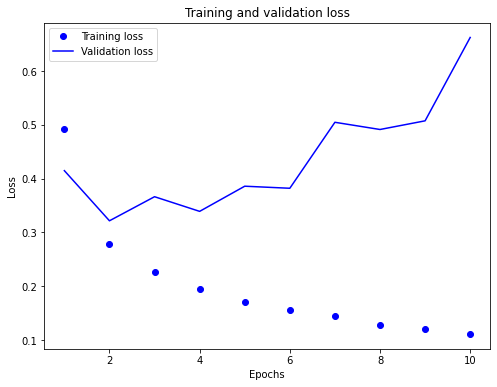

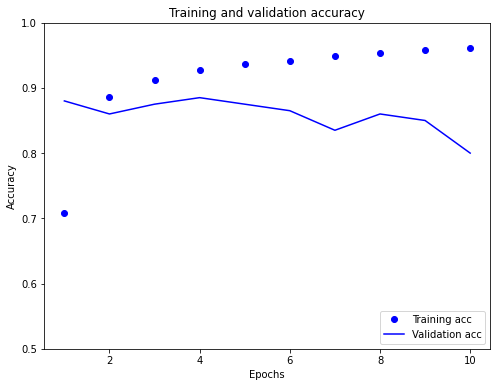

In [35]:
## plot it
h_dict = historty.history
acc = h_dict['accuracy']
v_acc = h_dict['val_accuracy']
los = h_dict['loss']
v_los = h_dict['val_loss']

epochs = range(1, len(acc)+1 )

plt.figure(figsize=(8,6))
plt.plot(epochs, los, 'bo', label='Training loss')
plt.plot(epochs, v_los, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, v_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [36]:
## Retrieving the word embeddings learnt during training
e_layer = model2.layers[0]
e_weights = e_layer.get_weights()[0]

print('shape: (vocab_size, embedding_dim)', e_weights.shape )

e_weights

shape: (vocab_size, embedding_dim) (8185, 16)


array([[ 0.02762489, -0.01389265, -0.01915953, ..., -0.02048966,
        -0.00591026,  0.07408127],
       [-0.04557168,  0.01023355, -0.05564443, ..., -0.032729  ,
         0.08119696,  0.06299481],
       [-0.0298725 , -0.02709462, -0.10048167, ..., -0.07991067,
         0.04869033,  0.0176893 ],
       ...,
       [-0.03100631,  0.04388758, -0.02521298, ...,  0.030868  ,
        -0.03271617, -0.04126625],
       [ 0.01514781, -0.0452388 , -0.02968427, ..., -0.01589551,
        -0.00329635,  0.01389796],
       [-0.03155911, -0.00072681,  0.0270893 , ..., -0.02695824,
        -0.04032071,  0.04387034]], dtype=float32)

In [37]:
## save the weights for reuse 
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for n, w in enumerate( encoder.subwords):
    vec = e_weights[n+1] ## skipping 0 b/c it's padding 
    out_m.write( w+"\n")
    out_v.write( '\t'.join([ str(x) for x in vec]) + "\n" ) 

out_v.close()
out_m.close()


In [38]:
## visualize the embeddings using Embedding Projector, which can also run in a  TensorBoard instance 
# http://projector.tensorflow.org/ << load the above two files here 